# Batch Predictions for an Image Classification model trained using AutoML.

**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace. [Check this notebook for creating a workspace](../../../resources/workspace/workspace.ipynb) 
- A Compute Cluster. [Check this notebook to create a compute cluster](../../../resources/compute/compute.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md) - check the getting started section

**Learning Objectives** - By the end of this tutorial, you should be able to:
- Connect to your AML workspace from the Python SDK
- Create an `AutoML Image Classification Multiclass Training Job` with the 'image_classification()' factory-function.
- Train the model using AmlCompute by submitting/running the AutoML training job
- Obtain the best model, register it and deploy it to a batch endpoint
- Generate batch predictions using the batch endpoint

**Please note**: For this notebook you can use an existing image classification model trained using AutoML for Images or use the simple model training we included below for convenience. For detailed instructions on how to train an image classification model with AutoML, please refer to the official [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2) and to the image classification multiclass [notebook](../automl-image-classification-multiclass-task-fridge-items/automl-image-classification-multiclass-task-fridge-items.ipynb).


# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input
from azure.ai.ml.automl import ImageClassificationSearchSpace
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [2]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

Found the config file in: C:\Users\rvadthyavath\work\projects\onnx_devplatv2\sdk\jobs\automl-standalone-jobs\config.json


# 2. MLTable with input Training Data

In order to generate models for computer vision tasks with automated machine learning, you need to bring labeled image data as input for model training in the form of an MLTable. You can create an MLTable from labeled training data in JSONL format. If your labeled training data is in a different format (like, pascal VOC or COCO), you can use a conversion script to first convert it to JSONL, and then create an MLTable. Alternatively, you can use Azure Machine Learning's [data labeling tool](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-image-labeling-projects) to manually label images, and export the labeled data to use for training your AutoML model.

In this notebook, we use a toy dataset called Fridge Objects, which consists of 134 images of 4 classes of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds.

All images in this notebook are hosted in [this repository](https://github.com/microsoft/computervision-recipes) and are made available under the [MIT license](https://github.com/microsoft/computervision-recipes/blob/master/LICENSE).

**NOTE:** In this PRIVATE PREVIEW we're defining the MLTable in a separate folder and .YAML file.
In later versions, you'll be able to do it all in Python APIs.

## 2.1. Download the Data
We first download and unzip the data locally.

In [3]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/image_classification/fridgeObjects.zip"
data_file = "fridgeObjects.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path="./data")
    print("done")

# delete zip file
os.remove(data_file)

extracting files...
done


This is a sample image from this dataset:

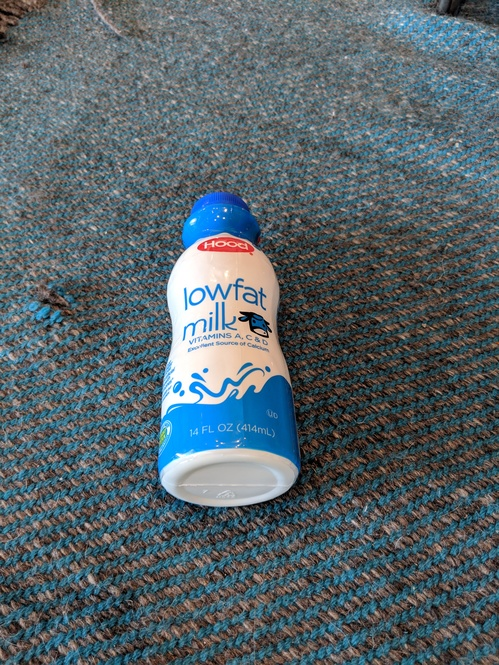

In [4]:
from IPython.display import Image

sample_image = "./data/fridgeObjects/milk_bottle/99.jpg"
Image(filename=sample_image)

## 2.2. Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

[Check this notebook for AML data asset example](https://github.com/Azure/azureml-examples/blob/b674293eaec6c60cb26cb3e5672c100c41ab4769/sdk/assets/data/data.ipynb)

In [3]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

my_data = Data(
    path="./data/fridgeObjects",
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images",
    name="fridge-items-images",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'fridge-items-images', 'description': 'Fridge-items images', 'tags': {}, 'properties': {}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/automlimage_eastus2_rg/providers/Microsoft.MachineLearningServices/workspaces/nilesh-deployment-test/data/fridge-items-images/versions/7', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_05_01.models._models_py3.SystemData object at 0x0000019AD9E88708>, 'serialize': <msrest.serialization.Serializer object at 0x0000019AD8E33888>, 'version': '7', 'latest_version': None, 'path': 'azureml://subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/automlimage_eastus2_rg/workspaces/nilesh-deployment-test/datastores/workspaceblobstore/paths/LocalUpload/c6876bbc27a0df81f0e4ed8195c62311/fridgeObjects/'})

Path to folder in Blob Storag

## 2.3 Convert the downloaded data to JSON metadata

In this example, the fridge object dataset is stored in a directory. There are four different folders inside:

/water_bottle
/milk_bottle
/carton
/can

This is the most common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside.

In order to use this data to create an AzureML MLTable, we first need to convert it to the required JSONL format. 

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [4]:
import json
import os

src_images = "./data/fridgeObjects/"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = "./data/training-mltable-folder/"
validation_mltable_path = "./data/validation-mltable-folder/"

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": "",
}

index = 0
# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for className in os.listdir(src_images):
            subDir = src_images + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ./data/fridgeObjects/can
Parsing ./data/fridgeObjects/carton
Parsing ./data/fridgeObjects/milk_bottle
Parsing ./data/fridgeObjects/water_bottle


## 2.4. Create MLTable data input
Create MLTable data input using the jsonl files created above.

In [5]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

To create data input from TabularDataset created using V1 sdk, specify the type as AssetTypes.MLTABLE, mode as InputOutputModes.DIRECT and path in the following format azureml:<tabulardataset_name>:<version>.

In [6]:
"""
# Training MLTable with v1 TabularDataset
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:fridgeObjectsTrainingDataset:1",
    mode=InputOutputModes.DIRECT
)

# Validation MLTable with v1 TabularDataset
my_validation_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:fridgeObjectsValidationDataset:1",
    mode=InputOutputModes.DIRECT
)
"""

'\n# Training MLTable with v1 TabularDataset\nmy_training_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:fridgeObjectsTrainingDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n\n# Validation MLTable with v1 TabularDataset\nmy_validation_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:fridgeObjectsValidationDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n'

# 3. Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-v2?tabs=cli#computes) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [32]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    ml_client.begin_create_or_update(compute_config)

Found existing compute target.


# 4. Configure and run the AutoML for Images Classification-MultiClass training job

AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model.

When using AutoML for image tasks, you need to specify the model algorithms using the model_name parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

## 4.1. Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

Following functions are used to configure the AutoML image job:
### image_classification() function parameters:
The `image_classification()` factory function allows user to configure the training job.

- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'gpu-cluster' present in the workspace. You can replace it any other compute in the workspace.
- `experiment_name` - The name of the experiment. An experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data' and 'validation_data'.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data"))
The parameter `training_data` must always be provided.


### set_limits() function parameters:
This is an optional configuration method to configure limits parameters such as timeouts.      
    
- `timeout_minutes` - Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. If not specified, the default job's total timeout is 6 days (8,640 minutes).
    
### set_image_model() function parameters:
This is an optional configuration method to configure fixed settings or parameters that don't change during the parameter space sweep. Some of the key parameters of this function are:

- `model_name` - The name of the ML algorithm that we want to use in training job. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#supported-model-algorithms) for supported model algorithm.
- `number_of_epochs` - The number of training epochs. It must be positive integer (default value is 15).
- `layers_to_freeze` - The number of layers to freeze in model for transfer learning. It must be a positive integer (default value is 0).
- `early_stopping` - It enable early stopping logic during training, It must be boolean value (default is True).   
- `optimizer` - Type of optimizer to use in training. It must be either sgd, adam, adamw (default is sgd).
- `distributed` - It enable distributed training if compute target contain multiple GPUs. It must be boolean value (default is True).
    
If you wish to use the default hyperparameter values for a given algorithm (say `vitb16r224`), you can specify the job for your AutoML Image runs as follows:

In [33]:
# set up experiment name
exp_name = "dpv2-image-classification-experiment"

In [34]:
# Create the AutoML job with the related factory-function.

image_classification_job = automl.image_classification(
    compute=compute_name,
    # name="dpv2-image-classification-job-02",
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    properties={

        "_automl_internal_scenario": "Vision-Candidate",

    }
)

image_classification_job.set_limits(timeout_minutes=60)

image_classification_job.set_image_model(model_name="vitb16r224")

### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [35]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"Created job: {returned_job}")

Created job: ImageClassificationJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'frank_fennel_fx5jl2xy8m', 'description': None, 'tags': {}, 'properties': {'_automl_internal_scenario': 'Vision-Candidate', 'mlflow.source.git.repoURL': 'https://github.com/Azure/azureml-examples.git', 'mlflow.source.git.branch': 'rvadthyavath/xai_vision', 'mlflow.source.git.commit': 'a91cdd766667e7e8eb914ef68b3c8f2b6cf017ce', 'azureml.git.dirty': 'True'}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/automlimage_eastus2_rg/providers/Microsoft.MachineLearningServices/workspaces/nilesh-deployment-test/jobs/frank_fennel_fx5jl2xy8m', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.SystemData object at 0x0000019A8003C108>,

In [36]:
ml_client.jobs.stream(returned_job.name)

RunId: frank_fennel_fx5jl2xy8m
Web View: https://ml.azure.com/runs/frank_fennel_fx5jl2xy8m?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/automlimage_eastus2_rg/workspaces/nilesh-deployment-test

Execution Summary
RunId: frank_fennel_fx5jl2xy8m
Web View: https://ml.azure.com/runs/frank_fennel_fx5jl2xy8m?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/automlimage_eastus2_rg/workspaces/nilesh-deployment-test



# 5. Retrieve the Best Trial (Best Model's trial/run)

Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

### Initialize MLFlow Client
The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface. Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT, you need to have installed the latest MLFlow packages with:

pip install azureml-mlflow

pip install mlflow
## 5.1 Obtain the tracking URI for MLFlow

In [37]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/automlimage_eastus2_rg/providers/Microsoft.MachineLearningServices/workspaces/nilesh-deployment-test


In [38]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))


Current tracking uri: azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/automlimage_eastus2_rg/providers/Microsoft.MachineLearningServices/workspaces/nilesh-deployment-test


In [39]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

## 5.2 Get the AutoML parent Job and find the best run

In [40]:
job_name = returned_job.name

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

{'model_explain_run': 'best_run', 'pipeline_id': '<UnkownPipelineId>;', 'score': '<1>;', 'predicted_cost': '<0>;', 'fit_time': '<NaN>;', 'training_percent': '<0>;', 'iteration': '<0>;', 'run_preprocessor': '<>;', 'run_algorithm': '<>;', 'automl_best_child_run_id': 'frank_fennel_fx5jl2xy8m_HD_0', 'mlflow.rootRunId': 'frank_fennel_fx5jl2xy8m', 'mlflow.runName': 'frank_fennel_fx5jl2xy8m', 'mlflow.user': 'Ramu Vadthyavath'}


In [41]:
# Get the best model's child run
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

Found best child run id:  frank_fennel_fx5jl2xy8m_HD_0


## 5.3 Download the best model locally

Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run and download them locally. We will need these artifacts when deploying the model.

In [42]:
import os

# Create local folder
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [ ]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

# 6. Deploy the non-MLFlow model with batch endpoints and run batch scoring

We will now deploy the non-MLFlow model to batch endpoint. Batch endpoint simply means, a REST endpoint which is capable of handing inputs in batch format.

To create a batch deployment, you need all the following items:

- **Model files**, or a registered model in your workspace referenced using `azureml:<model-name>:<model-version>`. In this notebook we will take the model file from the best_child_run.
- **The code to score the model**. 
- **The environment** in which the model runs. It can be a Docker image with Conda dependencies, or an environment already registered in your workspace referenced using `azureml:<environment-name>:<environment-version>`.  In this notebook we will create a environment object using the environment definition downloaded from the best_child_run artifacts.
- **The pre-created compute** referenced using `azureml:<compute-name>`.

## 6.1 Regsiter The Model in the workspace
For deploying the model, we first need to register it with the existing workspace so that we can discover it during runtime.

In [ ]:
from azure.ai.ml.entities import Model

tags = dict()
tags["accuracy"] = best_run.data.metrics["accuracy"]

model_name = "fridge-items-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/model.pt",
    name=model_name,
    description="fridge object classification model",
    tags=tags,
)

# for downloaded file
# model = Model(path="artifact_downloads/outputs/model.pt", name=model_name)

registered_model = ml_client.models.create_or_update(model)
registered_model.id

## 6.2 Configure environment
It is recommended to use the same envionment for model deployment as the model training, therefore we are creating the Environment object using the conda environment file downloaded as artifacts. We also need to specify the base image, which in case of vision tasks, is `mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.1-cudnn8-ubuntu18.04`

To read more about environments, please follow this [notebook](./../../../assets/environment/environment.ipynb)

In [ ]:
from azure.ai.ml.entities import Environment

env = Environment(
    name="automl-images-env",
    description="environment for automl images inference",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.1-cudnn8-ubuntu18.04",
    conda_file="artifact_downloads/outputs/conda_env_v_1_0_0.yml",
)

## 6.3 Get A Scoring Script

To do the scoring, you need to create a batch scoring script batch_scoring.py, and write it to the scripts folder in current directory. The script takes a minibatch of input images, applies the classification model, and outputs the predictions to a results file.

While creating the batch scoring script, refer to the scoring scripts generated under the outputs folder of the Automl training runs. This will help to identify the right model settings to be used in the batch scoring script init method while loading the model. Note: The batch scoring script we generate in the subsequent step is different from the scoring script generated by the training runs in the below screenshot. We refer to it just to identify the right model settings to be used in the batch scoring script.

![scoring-script.png](./ui_outputs_updated.jpeg)

### Understanding the scoring script

The scoring_script must contain two functions:

- init(): Use this function to load the model into a global object. This function will be called once at the beginning of the process.
- run(mini_batch): This function will be called for each mini_batch and do the actual scoring.
    + `mini_batch`: The mini_batch value is a list of file paths.
    + `result`: The run() method should return a pandas DataFrame or an array. Each returned output element indicates one successful run of an input element in the input mini_batch.
    
**Note** The scoring script used in this notebook is shown below

In [ ]:
# View the batch scoring script. Use the model settings as appropriate for your model.
with open("./scripts/batch_scoring.py", "r") as f:
    print(f.read())

## 6.4 Deploy the model to batch endpoint
**Now, let's deploy the model with batch endpoints and run batch scoring.** 

It has three steps.
- Create a batch endpoint
- configure the endpoint
- deploy the endpoint using MLClient.

### 6.4.1 Create A Batch Endpoint

**Please Note** that The name of the endpoint must be unique in the Azure region. For more information on the naming rules, see [managed endpoint limits](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-quotas#azure-machine-learning-managed-online-endpoints). 

Optionally, you can add description, tags to your endpoint.

In [ ]:
from azure.ai.ml.entities import (
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
)
from azure.ai.ml.constants import BatchDeploymentOutputAction

import datetime

batch_endpoint_name = "batch-endpoint-" + datetime.datetime.now().strftime("%Y%m%d%H%M")

# create a batch endpoint
endpoint = BatchEndpoint(
    name=batch_endpoint_name,
    description="Sample batch endpoint for classifying fridge objects",
    tags={"dataset": "fridge-objects"},
)

Using the MLClient created earlier, we'll now create the Endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

In [ ]:
ml_client.begin_create_or_update(endpoint)

### 6.4.2 Create batch compute

Batch endpoint runs only on cloud computing resources. The cloud computing resource is a reusable virtual computer cluster. 
The following code creates an Azure Machine Learning compute cluster.

In [ ]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "cpu-cluster"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_DS3_V2",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=5,
    )
    ml_client.begin_create_or_update(compute_config)

### 6.4.3 Configure the deployment 

A deployment is a set of resources required for hosting the model that does the actual inferencing. We'll create a deployment for our endpoint using the BatchDeployment class.  This class allows user to configure the following key aspects.

- **name**: Name of the deployment.
- **endpoint_name**: Name of the endpoint to create the deployment under.
- **model**: The model to use for the deployment. This value can be either a reference to an existing versioned model in the workspace or an inline model specification.
- **environment**: The environment to use for the deployment. This value can be either a reference to an existing versioned environment in the workspace or an inline environment specification. It should of type `azure.ai.ml.entities.environment` 
- **code_path**: Path to the source code directory for scoring the model
- **scoring_script**: Relative path to the scoring file in the source code directory
- **compute**: Name of the compute target to execute the batch scoring jobs on
- **instance_count**: The number of nodes to use for each batch scoring job.
- **max_concurrency_per_instance**: The maximum number of parallel scoring_script runs per instance.
- **mini_batch_size**: The number of files the code_configuration.scoring_script can process in one run() call.
- **retry_settings**: Retry settings for scoring each mini batch.
- **max_retries**: The maximum number of retries for a failed or timed-out mini batch (default is 3)
- **timeout**: The timeout in seconds for scoring a mini batch (default is 30)
- **output_action**: Indicates how the output should be organized in the output file. Allowed values are append_row or summary_only. Default is append_row
- **output_file_name**: Name of the batch scoring output file. Default is predictions.csv
- **environment_variables**: Dictionary of environment variable name-value pairs to set for each batch scoring job.
- **logging_level**: The log verbosity level. Allowed values are warning, info, debug. Default is info.


For more details about the various arguments of the BatchDeployment method, please refer to the documentation [here](https://docs.microsoft.com/en-us/python/api/azure-ai-ml/azure.ai.ml.entities.batchdeployment?view=azure-python-preview)

In [ ]:
# create a batch deployment
deployment_name = "classification-model"
deployment = BatchDeployment(
    name=deployment_name,
    description="sample batch deployment for fridge objects classification model",
    endpoint_name=batch_endpoint_name,
    model=registered_model.id,
    code_path="./scripts",
    scoring_script="batch_scoring.py",
    environment=env,
    compute=compute_name,
    instance_count=2,
    max_concurrency_per_instance=2,
    mini_batch_size=5,
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name="predictions.csv",
    environment_variables={"batch_size": 5, "model_explainability": True,
                           'xai_parameters': {"xai_algorithm":"xrai"}},
    retry_settings=BatchRetrySettings(max_retries=3, timeout=30*15),
    logging_level="info",
)

### 6.4.4 Create the deployment

Using the `MLClient` created earlier, we'll now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [ ]:
ml_client.begin_create_or_update(deployment)

## 6.5 Test the endpoint with sample data

Using the MLClient created earlier, we'll get a handle to the endpoint. The endpoint can be invoked using the invoke command with the following parameters:

- **endpoint_name** - Name of the endpoint
- **input** - Dataset object holding the test dataset
- **deployment_name** - Name of the specific deployment to test in an endpoint
- **params_override** - Optionally, this parameter could be used to override the deployment configurations. 

For more details, please refer the documentation [here](https://docs.microsoft.com/en-us/python/api/azure-ai-ml/azure.ai.ml.operations.batchendpointoperations?view=azure-python-preview#azure-ai-ml-operations-batchendpointoperations-invoke)

In [ ]:
registered_data_asset = ml_client.data.get(name="fridge-items-images", label="latest")

test_data = Input(type=AssetTypes.URI_FILE, path=registered_data_asset.id)

# invoke the endpoint for batch scoring job
job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=test_data,
    deployment_name=deployment_name,  # name is required as default deployment is not set
    params_override=[{"mini_batch_size": "5"}, {"compute.instance_count": "1"}],
)

In [ ]:
# get the details of the job
job_name = job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

## 6.6 Download and review output

In [ ]:
output_dir = "./scoring_results"
ml_client.jobs.download(
    name=job.name, output_name=deployment.output_file_name, download_path=output_dir
)

# Print the first two lines of the output
# don't print more than one line in case of Explainability 
# as the image base64 string is quite large
no_lines_to_print = 2
result_file = os.path.join(output_dir, deployment.output_file_name)
with open(result_file) as f:
    for x in range(no_lines_to_print):
        print(next(f))

## 6.7 Choose a random file for visualization

In [ ]:
import random
import json

with open(result_file, "r") as f:
    contents = f.readlines()
rand_file = contents[random.randrange(len(contents))]
prediction = json.loads(rand_file)
print(prediction["filename"])
print(prediction["probs"])
print(prediction["labels"])

In [ ]:
# Download the image file from the datastore
file_path_list_on_vm = prediction["filename"].split("/")
local_file_path = (
    f"./data/fridgeObjects/{file_path_list_on_vm[-2]}/{file_path_list_on_vm[-1]}"
)
local_file_path

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(local_file_path)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

label_index = np.argmax(prediction["probs"])
label = prediction["labels"][label_index]
conf_score = prediction["probs"][label_index]

display_text = "{} ({})".format(label, round(conf_score, 3))
print(display_text)

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

# 7. Delete the endpoint
Delete the endpoint to release the resources

In [ ]:
ml_client.batch_endpoints.begin_delete(name=batch_endpoint_name)